In [30]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_2.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_32.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_27.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_107.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_42.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_68.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_84.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_52.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_71.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_75.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_99.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_60.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_85.tif
/kaggle/input/tracer/dataset-trace-2/dataset-trace-2/HP/150/s11_98.tif
/kaggl

In [1]:
!pip install --upgrade protobuf==3.20.1


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 4.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
google-cloud-translate 3.12.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0dev,>=3.19.5, but you have protobuf 3.20.1 which is incompatible.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.1 which is incompatible.
google-cloud-secret-manager 2.25.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<7.0.0,>=3.20.2, but you have protobuf 3.20.1 which is incompatible.
google-cloud

#### GPU Warnings in TensorFlow

While running CNN models on Kaggle, you may see warnings like:

- Unable to register cuFFT / cuDNN / cuBLAS factories
- Messages written to STDERR

These warnings usually occur when TensorFlow detects multiple GPU libraries but they do not prevent the code from running.  

If you want to **force CPU usage** to avoid GPU-related issues, you can set:

```python
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"


In [5]:
# ====================================================
# CELL 1: IMPORT LIBRARIES
# ====================================================
import os
import cv2
import numpy as np
from scipy.ndimage import median_filter
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import pickle


In [7]:
# ====================================================
# CELL 2: IMAGE PREPROCESSING FUNCTIONS
# ====================================================
def preprocess_image_cnn(image_path, size=(128, 128)):
    # Read image
    img = cv2.imread(image_path)
    if img is None:
        return None

    # Convert BGR → RGB
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize
    img = cv2.resize(img, size)

    # Apply denoising
    img = median_filter(img, size=3)

    # Normalize (0–1)
    img = img.astype("float32") / 255.0

    return img


def load_cnn_dataset(folder_path, label, size=(128, 128)):
    images = []
    labels = []

    # Recursive folder reading
    for root, dirs, files in os.walk(folder_path):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                path = os.path.join(root, file)
                img = preprocess_image_cnn(path, size)
                if img is not None:
                    images.append(img)
                    labels.append(label)

    return np.array(images), np.array(labels)


In [16]:
# ====================================================
# CELL 3: LOAD TWO DATASETS (RECURSIVE + PROGRESS PRINT)
# ====================================================

dataset1_path = "/kaggle/input/tracer/dataset-trace"
dataset2_path = "/kaggle/input/tracer/dataset-trace-2"

print("🔄 Processing Dataset 1...")
x1, y1 = load_cnn_dataset_recursive(dataset1_path, label=0)
print("✔ Done! Total images in Dataset 1:", len(x1))

print("\n🔄 Processing Dataset 2...")
x2, y2 = load_cnn_dataset_recursive(dataset2_path, label=1)
print("✔ Done! Total images in Dataset 2:", len(x2))

print("\n📌 Shapes before merging:")
print("Dataset 1:", x1.shape, y1.shape)
print("Dataset 2:", x2.shape, y2.shape)

# Merge datasets
X = np.concatenate([x1, x2], axis=0)
Y = np.concatenate([y1, y2], axis=0)

# One-hot encoding for CNN
Y_cat = to_categorical(Y, num_classes=2)

print("\n🎉 All datasets loaded successfully!")
print("➡ Final X shape:", X.shape)
print("➡ Final Y shape:", Y.shape)


🔄 Processing Dataset 1...
✔ Done! Total images in Dataset 1: 2200

🔄 Processing Dataset 2...
✔ Done! Total images in Dataset 2: 2304

📌 Shapes before merging:
Dataset 1: (2200, 128, 128, 3) (2200,)
Dataset 2: (2304, 128, 128, 3) (2304,)

🎉 All datasets loaded successfully!
➡ Final X shape: (4504, 128, 128, 3)
➡ Final Y shape: (4504,)


In [18]:
# ====================================================
# CELL 4: BUILD CNN MODEL
# ====================================================
model = Sequential([
    Conv2D(32, (3, 3), activation="relu", input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation="relu"),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(128, activation="relu"),
    Dropout(0.3),

    Dense(2, activation="softmax")
])

model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 57600)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 128)            │     7,372,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,392,578 (28.20 MB)

 Trainable params: 7,392,578 (28.20 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# ====================================================
# CELL 5: TRAIN MODEL
# ====================================================
history = model.fit(X, Y_cat, epochs=8, batch_size=16, verbose=1)


Epoch 1/8


I0000 00:00:1764815798.940507     119 service.cc:148] XLA service 0x7a79a800d3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764815798.943069     119 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1764815798.943102     119 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1764815799.423478     119 cuda_dnn.cc:529] Loaded cuDNN version 90300


 19/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.4453 - loss: 2.9566

I0000 00:00:1764815802.441764     119 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


282/282 ━━━━━━━━━━━━━━━━━━━━ 10s 15ms/step - accuracy: 0.7372 - loss: 0.7817
Epoch 2/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9246 - loss: 0.1894
Epoch 3/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9530 - loss: 0.1355
Epoch 4/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9685 - loss: 0.0936
Epoch 5/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9760 - loss: 0.0732
Epoch 6/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9731 - loss: 0.0658
Epoch 7/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9684 - loss: 0.0986
Epoch 8/8
282/282 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.9870 - loss: 0.0385


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.9924511545293073

Classification Report:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      2200
           1       1.00      0.99      0.99      2304

    accuracy                           0.99      4504
   macro avg       0.99      0.99      0.99      4504
weighted avg       0.99      0.99      0.99      4504


Confusion Matrix:
[[2200    0]
 [  34 2270]]


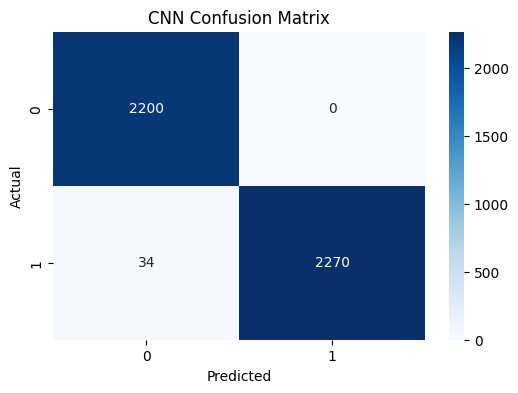

In [21]:
# ====================================================
# CELL 6: PREDICTION AND METRICS
# ====================================================
pred = model.predict(X)
pred_class = np.argmax(pred, axis=1)

acc = accuracy_score(Y, pred_class)
print("Accuracy:", acc)

print("\nClassification Report:")
print(classification_report(Y, pred_class))

print("\nConfusion Matrix:")
cm = confusion_matrix(Y, pred_class)
print(cm)

# ==== Confusion Matrix Plot ====
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [26]:
# ====================================================
# CELL 7: SAVE MODEL (IF NEEDED)
# ====================================================
with open("cnn_model.pkl", "wb") as f:
    pickle.dump(model, f)
print("Model saved as cnn_model.pkl")


Model saved as cnn_model.pkl


In [29]:
# ====================================================
# CELL 8: PREDICT NEW IMAGE
# ====================================================
def predict_image_cnn(image_path):
    img = preprocess_image_cnn(image_path)
    if img is None:
        print("Image not found or invalid!")
        return None

    img = np.expand_dims(img, axis=0)
    pred = model.predict(img)
    return np.argmax(pred)  # 0 or 1

# Example usage:
# predict_image_cnn("/kaggle/input/new_image.jpg")
